## 2° Teste

Pretendo seguir com o método utilizado no  2° teste, o diferencial aqui será tentar melhorar tresholding. A ideia será criar um método de segmentação semi-automáico, no qual o usuário precisa fornecer um pixel da imagem contido no CC.

In [1]:
# Importando pacotes

import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
import skimage.filters as skf
from skimage.segmentation import watershed
from skimage.morphology import remove_small_holes, remove_small_objects
import nibabel as nib
import pandas as pd
import cv2 as cv

In [2]:
# Definindo funções e variáveis para carregar imagens
dir_name = "../data/raw/"
img_data = pd.read_csv("../data/description.csv", dtype=str)

def getFilenameFromID(df, Id):
    file_name = "CC"
    for h in df.columns:
        file_name+=df[h][Id]+'_'
    file_name= file_name[:-1]+".nii"
    return file_name

def loadRandomImage():
    # Carrega imagem como um ndarray
    random_id = np.random.randint(0,high=358)
    file_name = getFilenameFromID(img_data, random_id)
    f = nib.load(dir_name+file_name).get_fdata()
    
    # Retira a fatia sagital central da imagem e
    # a rotaciona para uma posição mais natural 
    # e a coloca no intervalo de 0 a 255
    x = int(f.shape[0]/2)
    img = ndi.rotate(f[x,:,:], 90)
    img = 255*img/np.max(img)
    img = img.astype(np.uint8)
    
    return img, file_name

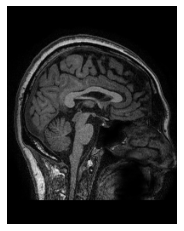

CC0292_ge_15_60_F.nii (256, 200)


In [3]:
# Carregando uma imagem aleatória

img, file_name = loadRandomImage()
plt.imshow(img, cmap='gray')
plt.axis("off")
plt.show()
print(file_name, img.shape)

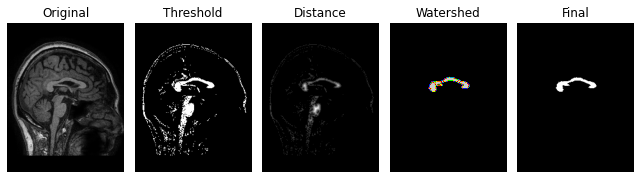

In [8]:
# Determinando valores a serem usados como marcador para o watershed
# e como ponto em torno do qual é feito o threshold.

# Ao executar esta célula, uma janela com a imagem seleciona irá aparecer.
# Tudo o que precisa fazer é clicar com o botão direito em um pixel contido no CC
# e então fechar a janela ou apertar a tecla "q".
target_value, target_x, target_y = 0,0,0 
n_mean = 5
mean_filter = 1/(n_mean**2)*np.ones((n_mean, n_mean))
mean_img = skf.edges.convolve(img, mean_filter)


def getPixelValue(event, x, y, flags, param):
    global target_value, target_x, target_y
    if event == cv.EVENT_LBUTTONDOWN:
        target_value = mean_img[y,x]
        target_x = x
        target_y = y

cv.namedWindow("SelectCC", cv.WINDOW_AUTOSIZE)
cv.setMouseCallback("SelectCC", getPixelValue)
while (True):
    cv.imshow("SelectCC", img)
    if cv.waitKey(1) == ord('q'):
        break
    
    if cv.getWindowProperty("SelectCC",cv.WND_PROP_VISIBLE) < 1:        
        break      

cv.destroyAllWindows()

# Watershed
threshold_img = np.ones(img.shape, np.int8)
lower_limit, upper_limit = max(target_value-20, 0), min(target_value+20, 255)
threshold_img[img < lower_limit] = 0
threshold_img[img > upper_limit] = 0

distance = ndi.distance_transform_edt(threshold_img)

markers = np.zeros(distance.shape, dtype=bool) 
markers = (distance==0)*1
markers[target_y,target_x] = 2

labels = watershed(-distance, markers)


# Removendo objetos pequenos e buracos
f0 = remove_small_holes(labels-1, 64)
final = remove_small_objects(f0, min_size=300)

# Plot
fig, axes = plt.subplots(ncols=5, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(img, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[1].imshow(threshold_img, cmap=plt.cm.gray)
ax[1].set_title('Threshold')
ax[2].imshow(distance, cmap=plt.cm.gray)
ax[2].set_title('Distance')
ax[3].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[3].set_title('Watershed')
ax[4].imshow(final, cmap=plt.cm.gray)
ax[4].set_title('Final')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()